Machine Translation - English to German

In [114]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"
print(tf.__version__)

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


import random

import tensorflow as tf
import string
import re 
from keras import layers
import io

2.9.1


In [115]:
#input_text_file_path = "./preprocessed_dataset_for_dev.txt"
input_text_file_path = "./preprocessed_dataset_for_train.txt"

In [116]:
with open(input_text_file_path, encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]

text_pairs = []

for line in lines:
    english, port = line.split("\t")
    port = "[start] " + port + " [end]"
    #if(random.random() > 0.25):
    text_pairs.append((english, port))

print(text_pairs[-1])

('the bookmarked feed shows the posts that you have bookmarked. the bookmarked feed offers easy access to useful posts.', '[start] im feed mit lesezeichen werden alle post angezeigt, die sie mit einem lesezeichen versehen haben. der feed "mit lesezeichen" bietet ihnen schnellen zugriff auf nützliche posts. [end]')


In [117]:
random.shuffle(text_pairs) #1. mistura todos os pairs

print("len(text_pairs) ->", len(text_pairs))

num_val_samples = int(0.15 * len(text_pairs))
print("15% for validation ->", num_val_samples)

num_train_samples = len(text_pairs) - 2 * num_val_samples
print("70% for train ->", num_train_samples)

train_pairs = text_pairs[:num_train_samples] #escolhe os primeiros 70% (shuffled) para treino
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples] #mais 15% para validação
test_pairs = text_pairs[num_train_samples + num_val_samples:] #mais 15 para teste

len(text_pairs) -> 100611
15% for validation -> 15091
70% for train -> 70429


In [118]:
print("treino: ",    len(train_pairs))
print("validação: ", len(val_pairs  ))
print("teste: ",     len(test_pairs ))

treino:  70429
validação:  15091
teste:  15091


In [119]:
strip_chars = string.punctuation # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

strip_chars = strip_chars.replace("[", "") # para não perder o [start] e [end]
strip_chars = strip_chars.replace("]", "") #

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 20000    # O modelo apneas vai conhecer 15000 palavras
sequence_length = 20  # cada frase vai ter 20 palavrasg


source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

print(train_pairs[0])
train_english_texts = [pair[0] for pair in train_pairs] 
print(train_english_texts[0])

train_pt_texts = [pair[1] for pair in train_pairs] 
print(train_english_texts[1])

source_vectorization.adapt(train_english_texts)
#source_vectorization.adapt([pair[0] for pair in text_pairs] )
target_vectorization.adapt(train_pt_texts)

('english (jamaica)', '[start] englisch (jamaika) [end]')
english (jamaica)
to send the message, click send or press enter on your keyboard.


In [120]:
source_vectorization.get_vocabulary()[0:10]

['', '[UNK]', 'the', 'to', 'a', 'and', 'in', 'you', 'for', 'your']

In [121]:
target_vectorization.get_vocabulary()[0:10]

['', '[UNK]', '[start]', '[end]', 'sie', 'die', 'der', 'und', 'in', 'für']

In [122]:
glove50_file_path = "./glove.6B.50d.embedding"

embeddings_index = {}

with open(glove50_file_path, encoding="utf-8") as gloveFile:
    for line in gloveFile:
        word, coefsAsString = line.split(maxsplit=1)
        coefs = np.fromstring(coefsAsString, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"EN embeddings has {len(embeddings_index)} word vectors")


EN embeddings has 400000 word vectors


In [123]:
en_embeddings_dim = 50

en_vocabulary = source_vectorization.get_vocabulary() 

word_index = dict(zip(en_vocabulary, range(len(en_vocabulary)))) # setting an "id" to head word 

embedding_matrix = np.zeros((vocab_size, en_embeddings_dim)) 
print("embedding_matrix size:", embedding_matrix.shape)

for word, i in word_index.items():
    if(i < vocab_size):
        embedding_vector = embeddings_index.get(word)

    if(embedding_vector is not None):
        embedding_matrix[i] = embedding_vector

#print(embedding_matrix[3:5])

en_embedding_layer = layers.Embedding(vocab_size, en_embeddings_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix))

embedding_matrix size: (20000, 50)


In [124]:
batch_size = 32

def format_dataset(eng, pt):
    eng = source_vectorization(eng)
    pt = target_vectorization(pt)
    return ({
        "english": eng,
        "portuguese": pt[:, :-1],
    }, pt[:, 1:])

def make_dataset(pairs):
    eng_texts, pt_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    pt_texts = list(pt_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, pt_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [125]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['portuguese'].shape: {inputs['portuguese'].shape}")
    print(f"targets.shape: {targets.shape}")
    #print(inputs['english'])


inputs['english'].shape: (32, 20)
inputs['portuguese'].shape: (32, 20)
targets.shape: (32, 20)


In [126]:
# Criação da classe que modela o Encoder 

# Na criação do objeto recebe 
# embed_dim: Dimensão da sequência de input 
# dense_dim: Número de nós da camada Dense
# num_heads: Número de attention heads

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dense_proj_sequential ,**kwargs):

        super().__init__(**kwargs)
        
        self.embed_dim = embed_dim
        
        self.dense_dim = dense_dim
        
        self.num_heads = num_heads
        
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        #self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.dense_proj = keras.Sequential(dense_proj_sequential)
        
        self.layernorm_1 = layers.LayerNormalization()
        
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        
        attention_output = self.attention(inputs, inputs, attention_mask=mask)

        proj_input = self.layernorm_1(inputs + attention_output)
        
        proj_output = self.dense_proj(proj_input)
        
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        
        return config

In [127]:
# Criação da classe que modela o Decoder 

# Na criação do objeto recebe 
# embed_dim: Dimensão da sequência de input 
# dense_dim: Número de nós da camada Dense
# num_heads: Número de attention heads

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dense_proj_sequential, **kwargs):
        
        super().__init__(**kwargs)
        
        self.embed_dim = embed_dim
        
        self.dense_dim = dense_dim
        
        self.num_heads = num_heads
        
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        #self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.dense_proj = keras.Sequential(dense_proj_sequential)
        
        self.layernorm_1 = layers.LayerNormalization()
        
        self.layernorm_2 = layers.LayerNormalization()
        
        self.layernorm_3 = layers.LayerNormalization()
        
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        
        return config

    def get_causal_attention_mask(self, inputs):
        
        input_shape = tf.shape(inputs)
        
        batch_size, sequence_length = input_shape[0], input_shape[1]
        
        i = tf.range(sequence_length)[:, tf.newaxis]
        
        j = tf.range(sequence_length)
        
        mask = tf.cast(i >= j, dtype="int32")
        
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        
        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], axis=0)
        
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        
        causal_mask = self.get_causal_attention_mask(inputs)
        
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask)
        
        attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)

        proj_output = self.dense_proj(attention_output_2)
        
        return self.layernorm_3(attention_output_2 + proj_output)

In [128]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, wordEmbedding=None, **kwargs):
        super().__init__(**kwargs)

        if( wordEmbedding is not None ):
            self.token_embeddings = wordEmbedding
        else:
            self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        
        self.sequence_length = sequence_length
        
        self.input_dim = input_dim
        
        self.output_dim = output_dim

    def call(self, inputs):
        
        length = tf.shape(inputs)[-1]
        
        positions = tf.range(start=0, limit=length, delta=1)
        
        embedded_tokens = self.token_embeddings(inputs)
        
        embedded_positions = self.position_embeddings(positions)
        
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()

        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })

        return config

In [129]:
# The complete Transformer

import keras
from keras.layers import Dense, BatchNormalization, Dropout, LayerNormalization
# Settings  
#embed_dim = 256
embed_dim = 50
dense_dim = 2048
num_heads = 6

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim, en_embedding_layer)(encoder_inputs)
encoder_outputs = TransformerEncoder(
    embed_dim,
    dense_dim,
    num_heads,
    [
        Dense(2048, activation="relu"), 
        BatchNormalization(),
        Dense(2048, activation="relu"), 
        BatchNormalization(),
        Dense(2048, activation="relu"), 
        BatchNormalization(),
        Dense(embed_dim, activation="relu"),
        BatchNormalization()
    ])(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="portuguese")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(
    embed_dim,
    dense_dim,
    num_heads,
    [
        Dense(2048, activation="relu"), 
        BatchNormalization(),
        Dense(2048, activation="relu"), 
        BatchNormalization(),
        Dense(2048, activation="relu"), 
        BatchNormalization(),
        Dense(embed_dim, activation="relu"), 
        BatchNormalization()
    ])(x, encoder_outputs)
x = Dropout(0.70)(x)  
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [130]:
keras.backend.clear_session()
best_model_file_path = "best_translator.tfmodel"
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience = 10, 
        min_delta = 0.005, 
        restore_best_weights = True,
        mode='auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = best_model_file_path,
        monitor = "val_accuracy",
        verbose=0,
        save_best_only = True,
        save_weights_only = False,
        mode='max'
    )
]

In [131]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [136]:
history = transformer.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/25
2201/2201 [==============================] - 128s 58ms/step - loss: 2.7485 - accuracy: 0.4535 - val_loss: 2.9035 - val_accuracy: 0.4112
Epoch 2/25
2201/2201 [==============================] - 123s 56ms/step - loss: 2.7328 - accuracy: 0.4572 - val_loss: 2.9203 - val_accuracy: 0.4042
Epoch 3/25
2201/2201 [==============================] - ETA: 0s - loss: 2.7187 - accuracy: 0.4610

INFO:tensorflow:Assets written to: best_translator.tfmodel\assets


INFO:tensorflow:Assets written to: best_translator.tfmodel\assets


2201/2201 [==============================] - 129s 59ms/step - loss: 2.7187 - accuracy: 0.4610 - val_loss: 2.8997 - val_accuracy: 0.4170
Epoch 4/25
2201/2201 [==============================] - 117s 53ms/step - loss: 2.7051 - accuracy: 0.4642 - val_loss: 2.9081 - val_accuracy: 0.4132
Epoch 5/25
2201/2201 [==============================] - 116s 53ms/step - loss: 2.6906 - accuracy: 0.4673 - val_loss: 2.8842 - val_accuracy: 0.4151
Epoch 6/25
2201/2201 [==============================] - 116s 53ms/step - loss: 2.6793 - accuracy: 0.4698 - val_loss: 2.9474 - val_accuracy: 0.4104
Epoch 7/25
2201/2201 [==============================] - 116s 53ms/step - loss: 2.6668 - accuracy: 0.4729 - val_loss: 2.9281 - val_accuracy: 0.4121
Epoch 8/25
2200/2201 [============================>.] - ETA: 0s - loss: 2.6546 - accuracy: 0.4758

INFO:tensorflow:Assets written to: best_translator.tfmodel\assets


INFO:tensorflow:Assets written to: best_translator.tfmodel\assets


2201/2201 [==============================] - 127s 58ms/step - loss: 2.6546 - accuracy: 0.4758 - val_loss: 2.9230 - val_accuracy: 0.4173
Epoch 9/25
2201/2201 [==============================] - 117s 53ms/step - loss: 2.6419 - accuracy: 0.4790 - val_loss: 2.9418 - val_accuracy: 0.4080
Epoch 10/25
2201/2201 [==============================] - 116s 53ms/step - loss: 2.6325 - accuracy: 0.4808 - val_loss: 2.9379 - val_accuracy: 0.4140
Epoch 11/25
2201/2201 [==============================] - 115s 52ms/step - loss: 2.6204 - accuracy: 0.4837 - val_loss: 2.9432 - val_accuracy: 0.4164
Epoch 12/25
2200/2201 [============================>.] - ETA: 0s - loss: 2.6105 - accuracy: 0.4858

INFO:tensorflow:Assets written to: best_translator.tfmodel\assets


INFO:tensorflow:Assets written to: best_translator.tfmodel\assets


2201/2201 [==============================] - 123s 56ms/step - loss: 2.6104 - accuracy: 0.4858 - val_loss: 2.9633 - val_accuracy: 0.4182
Epoch 13/25
2201/2201 [==============================] - ETA: 0s - loss: 2.6032 - accuracy: 0.4886

INFO:tensorflow:Assets written to: best_translator.tfmodel\assets


INFO:tensorflow:Assets written to: best_translator.tfmodel\assets


2201/2201 [==============================] - 128s 58ms/step - loss: 2.6032 - accuracy: 0.4886 - val_loss: 2.9571 - val_accuracy: 0.4205


<AxesSubplot:>

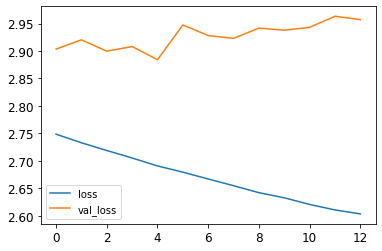

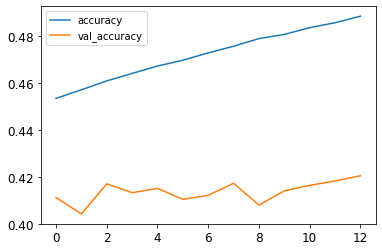

In [137]:
import pandas as pd 
history_frame =pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [134]:
# Testar o desempenho do Transformer em frases do conjunto de teste


pt_vocab = target_vectorization.get_vocabulary()
pt_index_lookup = dict(zip(range(len(pt_vocab)), pt_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
   
    tokenized_input_sentence = source_vectorization([input_sentence])
   
    decoded_sentence = "[start]"
   
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        
        sampled_token = pt_index_lookup[sampled_token_index]
        
        decoded_sentence += " " + sampled_token
        
        if sampled_token == "[end]":
            break
    
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]

for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
4a = 0.000000000000000004
[start] [UNK] [UNK] [end]
-
click dashboard properties to change the title, folder, running user, and more.
[start] klicken sie auf [UNK] ändern um den [UNK] und die [UNK] zu ändern [end]
-
your administrator correlates the values in this picklist with forecast category values that determine how the opportunity contributes to your forecast.
[start] die [UNK] ihrer organisation in dieser [UNK] werden mit der [UNK] [UNK] angezeigt die die der community die [UNK] für
-
name of the approval step.
[start] name des [UNK] [end]
-
to map engagement insights in community management or community workspaces:
[start] [UNK] in der [UNK] oder der [UNK] [end]
-
ensure that the edit date standard filter is set to current fq.
[start] legen sie das [UNK] fest die [UNK] wird auf [UNK] [UNK] [UNK] [end]
-
the opportunity amount field and each overlay sales team member's split percentage. for overlay splits - revenue forecasts, the split percentages don't need to total 100%. to 

In [135]:
for _ in range(5):
    input_sentence = input()
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence), '\n')

-

[start] [end] 

-

[start] [end] 

-

[start] [end] 

-

[start] [end] 

-

[start] [end] 

